In [20]:
def evaluation(question, answer):
    # 这里使用简单的示例评分，实际使用时请替换为真实的评估逻辑
    readability = 4  # 示例分数
    subject_suitability = 3
    complexity = 2
    return readability, subject_suitability, complexity

In [24]:
import re
import json
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# 文件路径
jsonl_file = '/home/dalhxwlyjsuo/guest_zhangx/rag_exercise_generator/data/intro/intro_chunks.jsonl'

# 正则表达式模式，用于提取问题和答案
question_pattern = re.compile(r'问题：<([^>]+)>')
answer_pattern = re.compile(r'答案：<([^>]+)>')

# 初始化一个列表，用于存储所有的问答对
qa_pairs = []

# 读取并解析JSONL文件
with open(jsonl_file, 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)
        entry_id = data.get('id')
        questions_dict = data.get('questions', {})
        
        for q_type, q_content in questions_dict.items():
            # 提取所有问题和答案
            questions_found = question_pattern.findall(q_content)
            answers_found = answer_pattern.findall(q_content)
            
            num_questions = len(questions_found)
            num_answers = len(answers_found)
            
            # 如果答案数量少于问题数量，用'NaN'填充
            if num_answers < num_questions:
                answers_found += ['NaN'] * (num_questions - num_answers)
            
            for question, answer in zip(questions_found, answers_found):
                qa_dict = {
                    "id": entry_id,
                    "type": q_type.strip(),
                    "question": question.strip(),
                    "answer": answer.strip()
                }
                qa_pairs.append(qa_dict)

# 输出示例
for qa in qa_pairs[:5]:  # 仅展示前5个
    print(json.dumps(qa, ensure_ascii=False, indent=4))

# 可选：将所有问答对保存到一个新的JSON文件中
output_file = 'parsed_qa_pairs.json'
with open(output_file, 'w', encoding='utf-8') as out_f:
    for qa in qa_pairs:
        json.dump(qa, out_f, ensure_ascii=False)
        out_f.write('\n')

print(f"\n已解析出 {len(qa_pairs)} 道问答对，并保存到 {output_file}。")


{
    "id": 70,
    "type": "条件",
    "question": "NaN",
    "answer": "NaN"
}
{
    "id": 70,
    "type": "预测",
    "question": "如果一个系统在发送数据时没有使用加密，那么它发送的数据将会是什么形式?",
    "answer": "明文形式"
}
{
    "id": 70,
    "type": "解释",
    "question": "TELNET协议在最初的设计中是为了做什么目的？",
    "answer": "代替TELNET"
}
{
    "id": 71,
    "type": "比较",
    "question": "NaN",
    "answer": "NaN"
}
{
    "id": 71,
    "type": "条件",
    "question": "NaN",
    "answer": "NaN"
}

已解析出 112 道问答对，并保存到 parsed_qa_pairs.json。


In [25]:
# Define the mapping from Chinese to English for question types
type_mapping = {
    '条件': 'Condition',
    '预测': 'Prediction',
    '解释': 'Explanation',
    '比较': 'Comparison',
    '因果': 'Causation',
    '评估': 'Evaluation',
    '程序': 'Procedure'
}

# Read the JSONL file
file_path = 'parsed_qa_pairs.json'  # Replace with your file path
data = []
try:
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
except FileNotFoundError:
    print(f"File not found: {file_path}")
    exit(1)
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    exit(1)

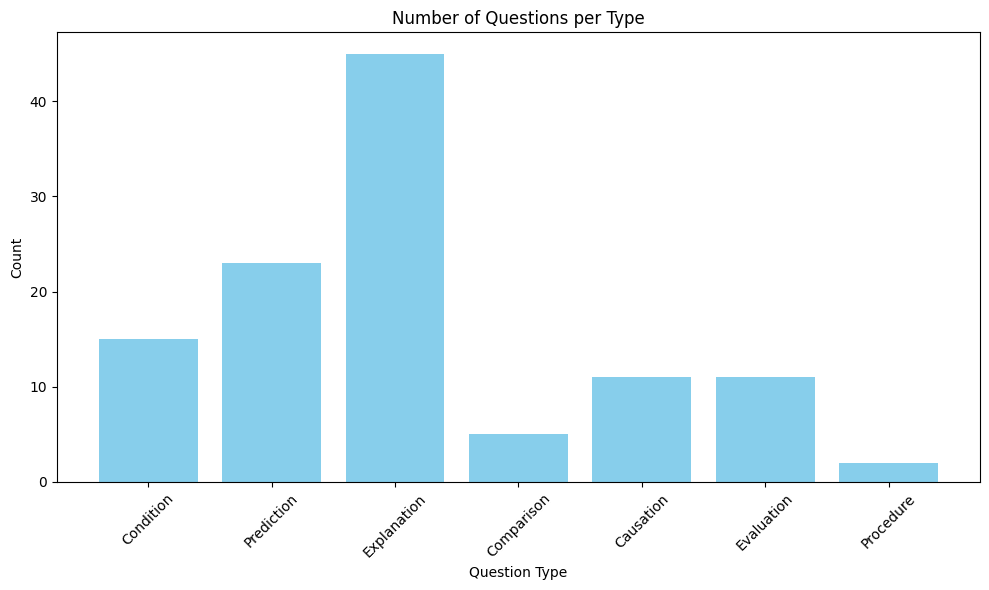

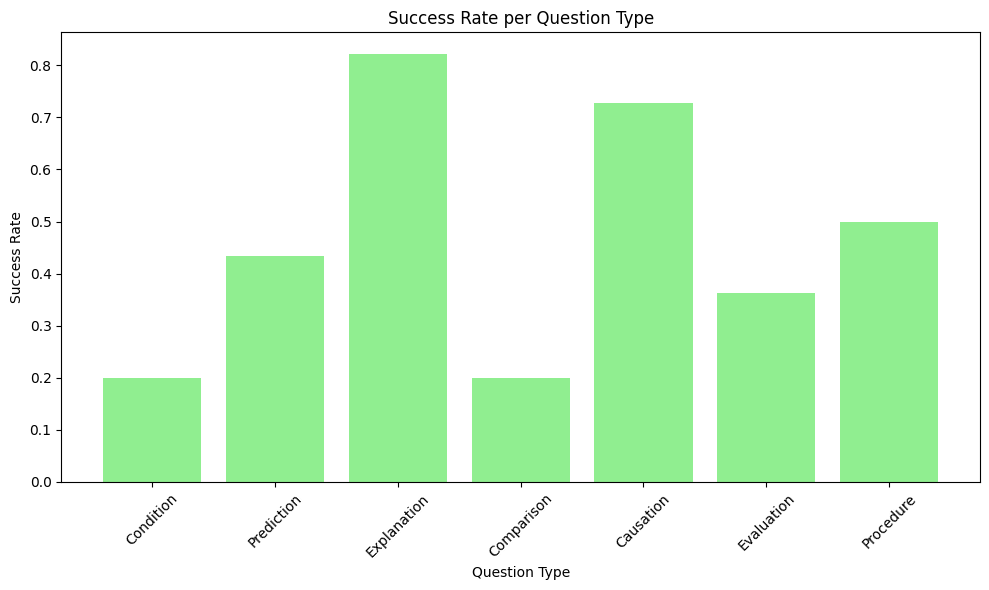

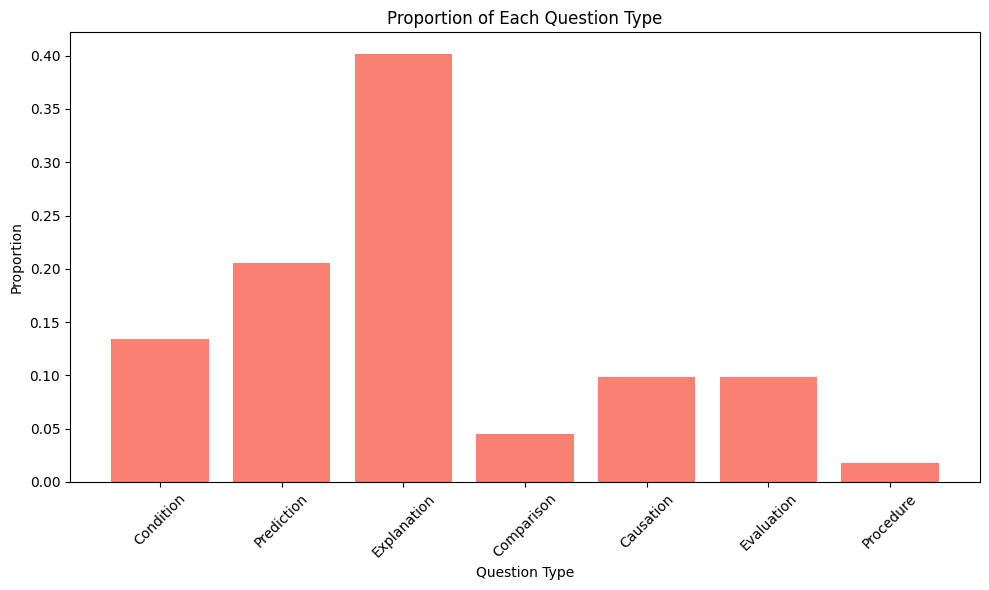

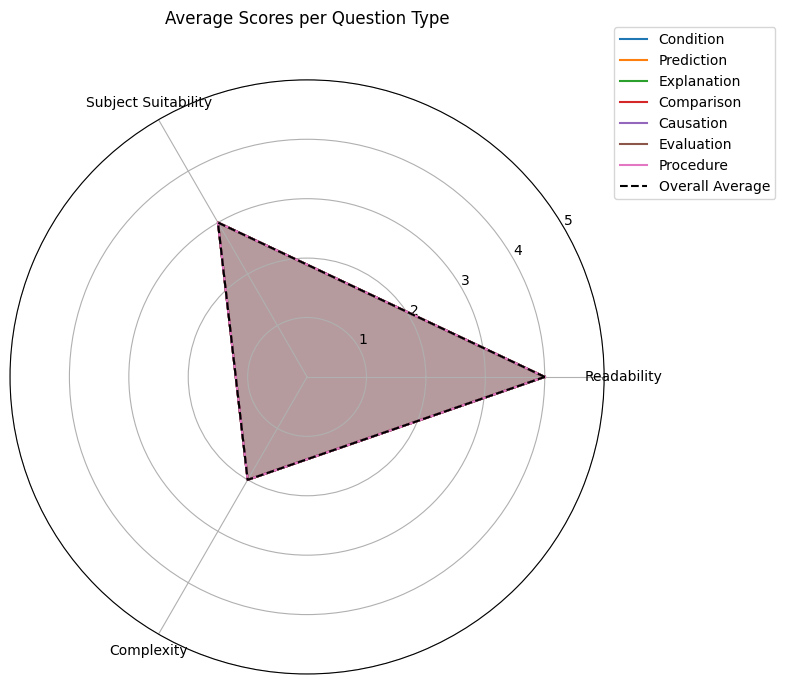

In [26]:
type_counts = {}
type_success = {}
type_scores = {}
total_count = len(data)

for entry in data:
    q_type = entry['type']
    if q_type not in type_counts:
        type_counts[q_type] = 0
        type_success[q_type] = 0
        type_scores[q_type] = {'readability': 0, 'subject_suitability': 0, 'complexity': 0, 'count': 0}
    type_counts[q_type] += 1
    if "NaN" not in entry['question'] and "question" not in entry['question'] :
        type_success[q_type] += 1
        readability, subject_suitability, complexity = evaluation(entry['question'], entry['answer'])
        type_scores[q_type]['readability'] += readability
        type_scores[q_type]['subject_suitability'] += subject_suitability
        type_scores[q_type]['complexity'] += complexity
        type_scores[q_type]['count'] += 1

# Calculate proportions and success rates
type_proportions = {}
type_success_rates = {}
for q_type in type_counts:
    type_proportions[q_type] = type_counts[q_type] / total_count
    type_success_rates[q_type] = type_success[q_type] / type_counts[q_type]

# Calculate average scores
average_scores = {}
for q_type in type_scores:
    count = type_scores[q_type]['count']
    if count > 0:
        average_scores[q_type] = {
            'readability': type_scores[q_type]['readability'] / count,
            'subject_suitability': type_scores[q_type]['subject_suitability'] / count,
            'complexity': type_scores[q_type]['complexity'] / count
        }
    else:
        average_scores[q_type] = {
            'readability': 0,
            'subject_suitability': 0,
            'complexity': 0
        }

# Calculate overall average scores
total_scores = {'readability': 0, 'subject_suitability': 0, 'complexity': 0}
total_evaluated = 0
for q_type in average_scores:
    total_scores['readability'] += average_scores[q_type]['readability'] * type_scores[q_type]['count']
    total_scores['subject_suitability'] += average_scores[q_type]['subject_suitability'] * type_scores[q_type]['count']
    total_scores['complexity'] += average_scores[q_type]['complexity'] * type_scores[q_type]['count']
    total_evaluated += type_scores[q_type]['count']

if total_evaluated > 0:
    total_average = {
        'readability': total_scores['readability'] / total_evaluated,
        'subject_suitability': total_scores['subject_suitability'] / total_evaluated,
        'complexity': total_scores['complexity'] / total_evaluated
    }
else:
    total_average = {'readability': 0, 'subject_suitability': 0, 'complexity': 0}

# Map Chinese types to English
mapped_types = [type_mapping.get(q_type, q_type) for q_type in type_counts.keys()]
mapped_counts = list(type_counts.values())

# Visualize the number of questions per type as a bar chart
plt.figure(figsize=(10,6))
plt.bar(mapped_types, mapped_counts, color='skyblue')
plt.xlabel('Question Type')
plt.ylabel('Count')
plt.title('Number of Questions per Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize the success rate per type as a bar chart
success_rates = [type_success_rates[q_type] for q_type in type_counts.keys()]
plt.figure(figsize=(10,6))
plt.bar(mapped_types, success_rates, color='lightgreen')
plt.xlabel('Question Type')
plt.ylabel('Success Rate')
plt.title('Success Rate per Question Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize the proportion of each question type as a bar chart
proportions = [type_proportions[q_type] for q_type in type_counts.keys()]
plt.figure(figsize=(10,6))
plt.bar(mapped_types, proportions, color='salmon')
plt.xlabel('Question Type')
plt.ylabel('Proportion')
plt.title('Proportion of Each Question Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Prepare data for the radar chart
labels = ['Readability', 'Subject Suitability', 'Complexity']
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# Plot average scores for each question type
for q_type in average_scores:
    scores = [
        average_scores[q_type]['readability'],
        average_scores[q_type]['subject_suitability'],
        average_scores[q_type]['complexity']
    ]
    scores += scores[:1]
    mapped_q_type = type_mapping.get(q_type, q_type)
    ax.plot(angles, scores, label=mapped_q_type)
    ax.fill(angles, scores, alpha=0.1)

# Plot overall average scores
total_scores_list = [
    total_average['readability'],
    total_average['subject_suitability'],
    total_average['complexity']
]
total_scores_list += total_scores_list[:1]
ax.plot(angles, total_scores_list, label='Overall Average', color='black', linestyle='--')
ax.fill(angles, total_scores_list, alpha=0.1, color='black')

# Set radar chart properties
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_rlabel_position(30)
ax.set_yticks([1,2,3,4,5])
ax.set_ylim(0,5)
plt.title('Average Scores per Question Type', y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

In [27]:
from main import *

In [29]:
with open('score.jsonl', 'w', encoding='utf-8') as correct_file:
    for entry in tqdm(data):
        question=entry['question']+entry['answer']
        score=dm.evaluate_question(question)
        entry['score']=score
        correct_file.write(json.dumps(entry, ensure_ascii=False) + '\n')
        

100%|██████████| 112/112 [07:13<00:00,  3.87s/it]


In [40]:
filtered_scores=[]
with open('score.jsonl', 'r', encoding='utf-8') as correct_file:
    for line in correct_file.readlines():
        data = json.loads(line)
        if 'NaN' not in data['question']:
            score=data['score']
            try:
                score = score.strip().replace("```json", "").replace("```", "").strip()
            except:
                continue
            clean_score = json.loads(score)
            data['score']=clean_score
            filtered_scores.append(data)

In [32]:
print(filtered_scores[0]['score'])

{'可读性': {'得分': 2, '说明': '题目由重复的字符组成，没有明确的语义，对于大多数学生来说理解起来困难，但语法上没有错误。'}, '适切性': {'得分': 0, '说明': '题目与任何学科内容都不相关，无法与任何教学目标对齐。'}, '复杂性': {'得分': 0, '说明': '题目没有认知挑战，过于简单，不要求任何推理或认知努力。'}}


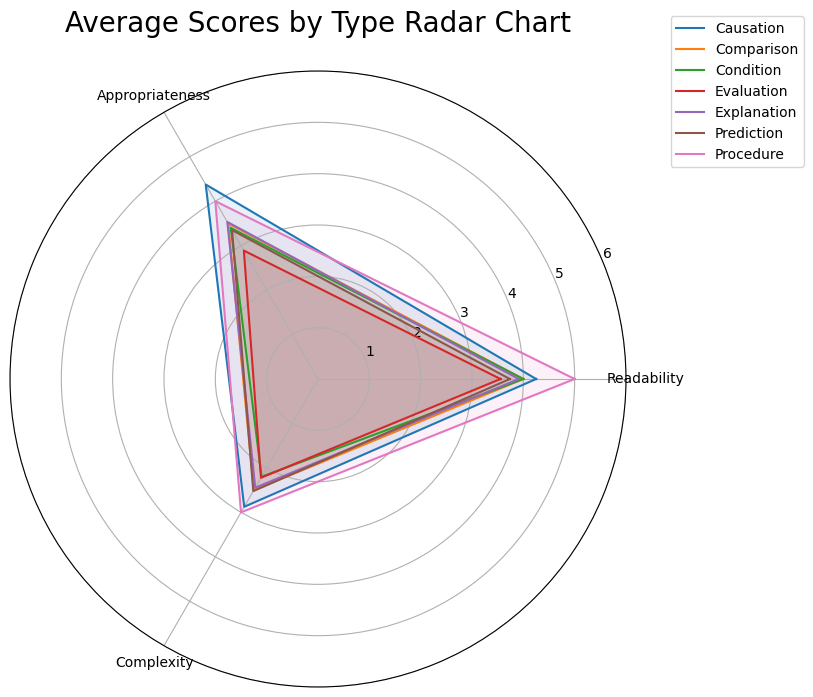

In [41]:
import pandas as pd
category_mapping = {
    '可读性': 'Readability',
    '适切性': 'Appropriateness',
    '复杂性': 'Complexity'
}
records = []
for entry in filtered_scores:
    type_en = type_mapping.get(entry['type'], entry['type'])
    scores = entry['score']
    record = {'Type': type_en}
    for category_cn, details in scores.items():
        category_en = category_mapping.get(category_cn, category_cn)
        record[category_en] = details['得分']
    records.append(record)

df = pd.DataFrame(records)

# 计算每种类型在各评分类别上的平均得分
df_avg = df.groupby('Type').mean()

# 雷达图的类别（英文）
categories = list(df_avg.columns)
num_categories = len(categories)

# 计算每个类别在雷达图上的角度
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
angles += angles[:1]  # 闭合图形

# 初始化雷达图
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# 绘制每种类型的雷达图
for idx, row in df_avg.iterrows():
    values = row.tolist()
    values += values[:1]  # 闭合图形
    ax.plot(angles, values, label=idx)
    ax.fill(angles, values, alpha=0.1)

# 设置类别标签（英文）
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# 设置雷达图的范围
max_score = df_avg.max().max()
ax.set_ylim(0, max_score + 1)

# 添加图例
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# 添加标题
plt.title('Average Scores by Type Radar Chart', size=20, y=1.05)

# 显示图形
plt.show()